<a href="https://colab.research.google.com/github/akshayonly/ML-Case-Study-Classifying-GM/blob/main/Classifying_Genetic_Mutation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effects of high dimensional features on machine learning models performance

1. Packages

2. Downloading data

3. Preprocessing data

4. Primary data analysis

5. Data featurization

   1. Text Feature

      - TF-IDF

   2. Categorical Features
      - Response encoding

6. Secondary data analysis

   1. Visualizing high dimensional text features by t-SNE
   2. Visualizing Gene & Variation features by  t-SNE

7. ML model building

   1. Linear models
      1. SVM-RBF
      2. Logistic Regression (SGD)
   2. Ensemble models
      1. Random Forest
      2. XGBoost

8. Conclusion

**OBJECTIVE**

The goal of this case study is to understand how different featurization technique affects the overall machine learning model performance. 

<a name="cell-id1"></a>
# Packages

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import re
from tqdm import tqdm
from datetime import datetime

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

palette = ['#006400', '#bc8f8f', '#ff4500', '#ffd700', '#00ff00', 
           '#00ffff', '#a020f0', '#1e90ff', '#ff1493'] 
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
start=datetime.now()

# Downloading data

In [ ]:
# Train Texts
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip' --output-document 'training_text.zip' && unzip training_text.zip

# Train Variants
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008828&Signature=daXpYlinA3JfM6dRDJO81AddsFlJ07GrZA%2FGaJHfHrhDEx69HUbj24gbH2ahVgwwjZtZ6FICDEefb8IoJXXceQEZEMy53%2Ff9QgMhI7PBgPFtQ3KgdzZ3%2BipqvntyPQlsa92qCBBwC91iG65TMB%2B4AjfhqydDUEtjNXiySnndKWwt04FZqTtHRf3LBvhwpf5mdi9U3Duk%2FI%2BnxDyoRwo1b2ffV3CJbNWDJSuXnN%2Fu8BmiCqndjVN6fi772VeXHn9R3vsgYEs4g%2FhTUFzSn%2FaW0%2FPrtKVhx%2Fd3QuqhQUh3%2BVNoI9qvFBB%2BlyyfyYUNBMsxrd0Oi6zkPmM8R2q6TeSTzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip' --output-document 'training_variants.zip' && unzip training_variants.zip

--2021-03-27 11:42:48--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   1

In [ ]:
!ls -I *.zip

training_variants.zip


<a name="cell-id3"></a>
# Data Preprocessing

In [ ]:
variants_data = pd.read_csv('/content/training_variants', index_col=False)
variants_data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
texts_data = pd.read_csv('/content/training_text', 
                         sep="\|\|", 
                         engine="python", 
                         names=["ID","TEXT"], 
                         skiprows=1)

texts_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Merging variants and texts dataframes

In [ ]:
data = pd.merge(texts_data, variants_data, on='ID', how='left')

data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


## Highlevel overview

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


1. There are 3321 entries in the dataframe.
2. Leaving ``Class`` column which is numerical representation of genetic mutation classes, rest are object datatype i.e. categorical and text.
3. The ``TEXT`` column have 05 entries lesser than the total 3321, we'd look at them later.

In [ ]:
data['Class'].describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

## Preprocessing

### NaN values

In [ ]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


- There are 05 rows in the data in the ``'TEXT'`` column which are NaN
- We'd  remove them, as these are text base and we cannot replace them with other values.

In [ ]:
data.dropna(subset = ["TEXT"], inplace=True)

### Standard NLP preprocessing
- Removing stop words
- Removing puntuations

In [ ]:
stop_words = set(stopwords.words('english'))

def text_processing(text):
  """Processing the sentence (single entry)."""

  text = re.sub('\s+',' ', text)
  text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
  text = text.lower()

  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

  return ' '.join(tokens)

In [ ]:
for index, text in tqdm(data.TEXT.iteritems()):
  data["TEXT"][index] = text_processing(text)

3316it [02:43, 20.27it/s]


In [ ]:
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

In [ ]:
data.head(2)

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating_Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2


In [ ]:
# Copying newly created dataframe into csv
# data.to_csv('CGM-processed.csv', index=False)

In [ ]:
# Copying to google drive
# !cp -r /content/CGM-processed.csv /content/drive/MyDrive/Data/CGV-Data

<a name="cell-id4"></a>
# Primary data analysis

## Distribution of ``Class``

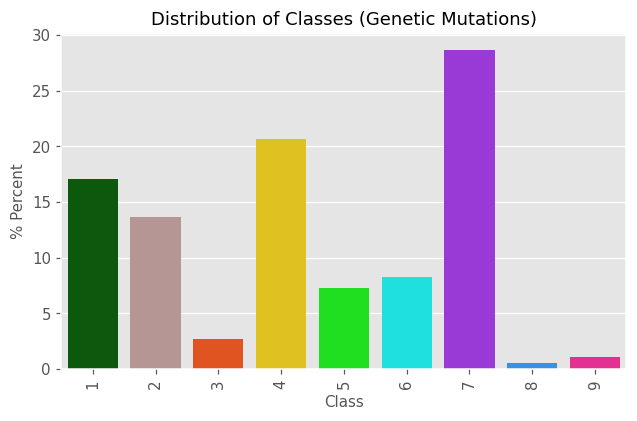

In [ ]:
plt.figure(figsize=(6,4), dpi=108)
sns.barplot(x="Class", y="Class", data=data, palette=palette,
            estimator=lambda x: len(x) / len(data) * 100)
plt.ylabel('% Percent', fontsize=10)
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation='vertical')
plt.title("Distribution of Classes (Genetic Mutations)", fontsize=12)
plt.tight_layout()
plt.show()

**Obsevation**
1. The class distribution is highly imbalanced. 
2. Most frequent genetic mutation classes are 7 (appx. 29%), followed by class 4 (appx. 21%).
3. Lowest occurancing classes are 8 and 9.
4. Due to presense of imbalance among classes, this can affect the predicition of the model, as it often noted that classes with major occurances tends to foreshadow those with less occurances.

<a name="cell-id5"></a>
# Data featurization

In [ ]:
y = np.array(data['Class'].values)

In [ ]:
X = data[data.columns[1:4]]

In [ ]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y)

In [ ]:
x_train.shape

(2321, 3)

In [ ]:
x_test.shape

(995, 3)

In [ ]:
x_test.head()

,TEXT,Gene,Variation
900,gastrointestinal stromal tumors gists commonly...,PDGFRA,S566_E571delinsR
2824,assessment influence many rare brca2 missense ...,BRCA2,R2520Q
2445,mutations brca1 brca2 account majority heredit...,BRCA1,S1651P
1513,introduction chromosomal translocations involv...,ALK,RANBP2-ALK_Fusion
200,purpose clinical features epidermal growth fac...,EGFR,L861Q


## Categorical

In [ ]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Gene'])

ohe_tr_gene = one_hot.transform(x_train['Gene'])
ohe_ts_gene = one_hot.transform(x_test['Gene'])

In [ ]:
print(f"OneHotEncoded Gene: {ohe_tr_gene.shape}")
print(f"OneHotEncoded Gene: {ohe_ts_gene.shape}")

OneHotEncoded Gene: (2321, 248)
OneHotEncoded Gene: (995, 248)


In [ ]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Variation'])

ohe_tr_var = one_hot.transform(x_train['Variation'])
ohe_ts_var = one_hot.transform(x_test['Variation'])

In [ ]:
print(f"OneHotEncoded Variation: {ohe_tr_var.shape}")
print(f"OneHotEncoded Variation: {ohe_ts_var.shape}")

OneHotEncoded Variation: (2321, 2148)
OneHotEncoded Variation: (995, 2148)


## Text

### TF-IDF 

In [ ]:
vec_start = datetime.now()

tfidf = TfidfVectorizer(ngram_range=(2, 4), 
                        max_features=3000).fit(x_train['TEXT'])

tfidf_tr_text = tfidf.transform(x_train['TEXT'])
tfidf_ts_text = tfidf.transform(x_test['TEXT'])

vec_end = datetime.now()
print(f"Took: {vec_end-vec_start}")

Took: 0:04:06.864971


In [ ]:
tfidf_ts_text.shape

(995, 3000)

In [ ]:
tfidf_tr_text.shape

(2321, 3000)

In [ ]:
%xdel tfidf

## Concatenation

In [ ]:
train = np.hstack((tfidf_tr_text.toarray(), 
                   ohe_tr_var.toarray(), 
                   ohe_tr_gene.toarray()))

test = np.hstack((tfidf_ts_text.toarray(), 
                  ohe_ts_var.toarray(), 
                  ohe_ts_gene.toarray()))

In [ ]:
print(f"Train X: {train.shape}\ty: {y_train.shape}")
print(f"Test X: {test.shape}\ty: {y_test.shape}")

Train X: (2321, 5396)	y: (2321,)
Test X: (995, 5396)	y: (995,)


## SVD-Feature reduction

In [108]:
reduced_dim=int(np.floor(5396/6))
reduced_dim

899

In [115]:
svd = TruncatedSVD(n_components=390)
train_reduced = svd.fit_transform(train)

svd = TruncatedSVD(n_components=390)
test_reduced = svd.fit_transform(test)

In [116]:
print(f"Reduced Dimensions\nTrain X: {train_reduced.shape}\ty: {y_train.shape}")
print(f"Test X: {test_reduced.shape}\ty: {y_test.shape}")

Reduced Dimensions
Train X: (2321, 390)	y: (2321,)
Test X: (995, 390)	y: (995,)


<a name="cell-id6"></a>
# Secondary data analysis

In [ ]:
# Reducing dimension and projecting it onto 2D with t-SNE
train_tsne = TSNE(n_components=2, perplexity=100).fit_transform(train) 

# Reducing dimension and projecting it onto 2D with t-SNE
test_tsne = TSNE(n_components=2, perplexity=100).fit_transform(test) 

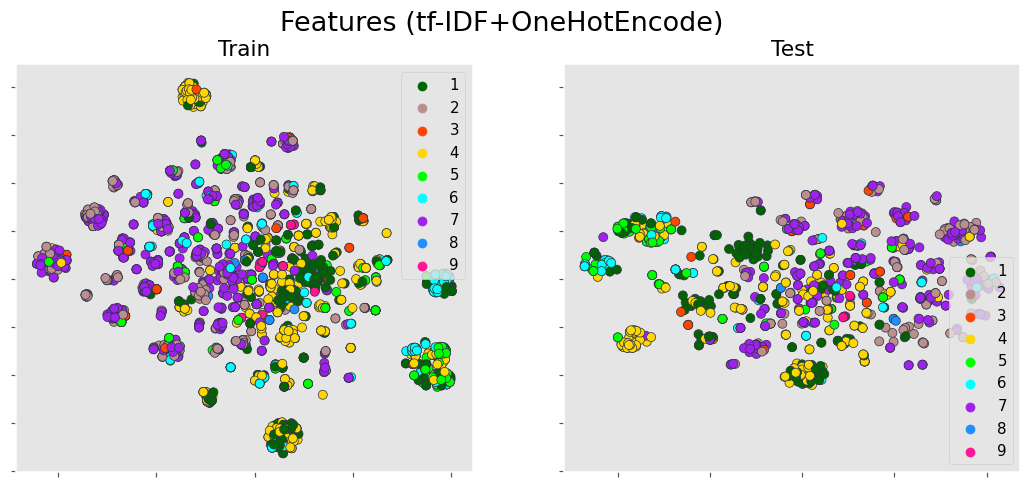

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=108, sharey=True)
fig.suptitle('Features (tf-IDF+OneHotEncode)', fontsize=18)

sns.scatterplot(ax=axes[0], x=train_tsne[:,0], y=train_tsne[:,1], edgecolor='#2f3542',
                hue=y_train, legend='full', palette=palette)
axes[0].set_title("Train")
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].grid(False)

sns.scatterplot(ax=axes[1], x=test_tsne[:,0], y=test_tsne[:,1], edgecolor='#2f3542',
                hue=y_test, legend='full', palette=palette)
axes[1].set_title("Test")
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].grid(False)

fig.savefig('QWERTT.png', dpi=300)

# Machine learning model

## Linear Models
- SVM with RBF & Polynomial kernel.
- Logistic Regression with Stochastic Gradient Descent

### SVM

Before building model we need to find the best parameters for the SVM. This can easily can be done with - Hyperparameters Tunning method. For this we'd use - Grid Search base approach.

### Logistic Regression

## Tree-Based
- Decision Tree
- Random Forest
- XGBoost

## Neighbourhood-Based
- k-Nearest Neighbours

#### All Features

In [ ]:
# https://stats.stackexchange.com/questions/384542/how-to-prevent-overfitting-with-knn
np.floor(np.log2(len(x_train))) 

11.0

In [58]:
params = {
    'n_neighbors':[3, 7, 11, 17, 21],
    'algorithm':['ball_tree', 'kd_tree'],
    'weights':['distance']
    }

knn = KNeighborsClassifier(n_jobs=-1)

knn_cv_start = datetime.now()
knn_cv = GridSearchCV(knn, param_grid=params, verbose=2, n_jobs=-1).fit(train, y_train) 
knn_cv_end= datetime.now()

best_knn=knn_cv.best_params_

print(f"\n\nTook {knn_cv_end-knn_cv_start} time to find best parameters:\n\t{best_knn}\n\n")

knn = KNeighborsClassifier(n_neighbors=best_knn['n_neighbors'],
                           weights=best_knn['weights'],
                           algorithm=best_knn['algorithm'],
                           n_jobs=-1)

knn.fit(train, y_train) 

# Prediction
y_predtest = knn.predict(test)
y_predtrain = knn.predict(train)

# Accuracy
print(f"Train Accuracy:\t{accuracy_score(y_predtrain, y_train)}")
print(f"Test Accuracy:\t{accuracy_score(y_predtest, y_test)}\n")

print("-"*100)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle('Confusion Matrix - kNN (High-Dimension)', fontsize=18)

cm1 = confusion_matrix(y_predtrain, y_train)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Reds', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_predtest, y_test)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished




Took 0:01:58.870357 time to find best parameters:
	{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}


#### Reduced Features dimensions

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.0s finished




Took 0:00:05.164506 time to find best parameters:
	{'n_neighbors': 21, 'weights': 'distance'}


Train Accuracy:	1.0
Test Accuracy:	0.2964824120603015

----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Test')

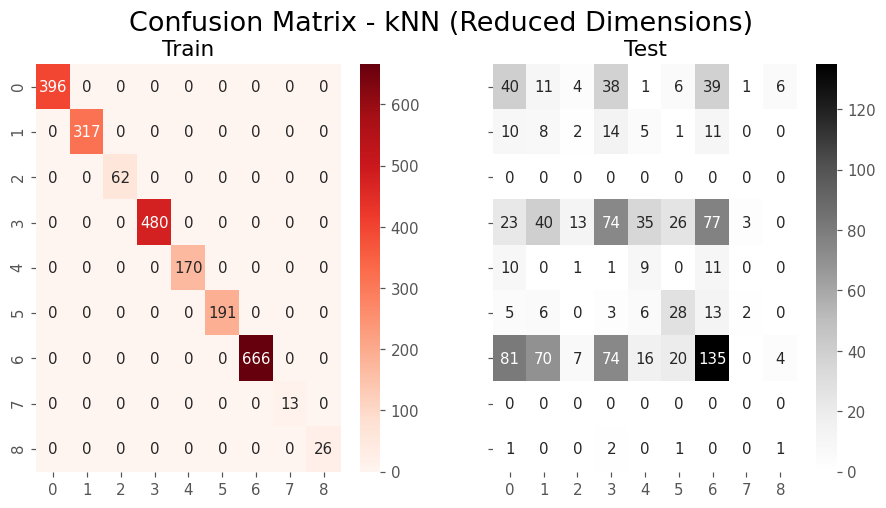

In [117]:
params = {
    'n_neighbors':[3, 7, 11, 17, 21],
    'weights':['distance']
    }

knn = KNeighborsClassifier(n_jobs=-1)

knn_cv_start = datetime.now()
knn_cv = GridSearchCV(knn, param_grid=params, verbose=2, n_jobs=-1).fit(train_reduced, y_train) 
knn_cv_end= datetime.now()

best_knn=knn_cv.best_params_

print(f"\n\nTook {knn_cv_end-knn_cv_start} time to find best parameters:\n\t{best_knn}\n\n")

knn = KNeighborsClassifier(n_neighbors=best_knn['n_neighbors'],
                           weights=best_knn['weights'],
                           n_jobs=-1)

knn.fit(train_reduced, y_train) 

# Prediction
y_predtest = knn.predict(test_reduced)
y_predtrain = knn.predict(train_reduced)

# Accuracy
print(f"Train Accuracy:\t{accuracy_score(y_predtrain, y_train)}")
print(f"Test Accuracy:\t{accuracy_score(y_predtest, y_test)}\n")

print("-"*100)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
fig.suptitle('Confusion Matrix - kNN (Reduced Dimensions)', fontsize=18)

cm1 = confusion_matrix(y_predtrain, y_train)
sns.heatmap(cm1, annot=True,fmt="d",cmap='Reds', ax=axes[0])
axes[0].set_title('Train')

cm2 = confusion_matrix(y_predtest, y_test)
sns.heatmap(cm2, annot=True,fmt="d",cmap='Greys', ax=axes[1])
axes[1].set_title('Test')

<a name="cell-id8"></a>
# Conclusion

In [ ]:
end=datetime.now()

print(f"Time took for whole Notebook - {end-start}")

Time took for whole Notebook - 0:10:30.282691


In [ ]:
! rm /content/training_variants

In [ ]:
! rm /content/training_text

In [ ]:
!rm -I *.zip